In [7]:
pip install scikit-survival lifelines statsmodels

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.5/847.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 6.2 MB/s eta 0:00:00a 0:00:01
  Created wheel for ecos: filename=ecos-2.0.14-cp312-cp312-macosx_11_0_arm64.whl size=72521 sha256=df6db73109eb3b924aeefdf90e072ffef66d28e8184ad94aa27c1d3bcd01a9c5
  Stored in directory: /Users/veronicacruz/Library/Caches/pip/wheels/b8/d9/1e/77a592ed2465d4dde07f30f787f9d43834c0fd7a1467371694
Successfully built ecos
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.1
    Uninstalling scikit-learn-1.5.1:
      Successfully uninstalled scikit-learn-1.5.1
Note: you may need to restart the kernel to use updated packages.


### Import Libraries 

In [1]:
#====================================================#
#           Data Manipulation and Plotting           #
#====================================================#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

#====================================================#
#       Kaplan-Meier, Cox and RSF and  Analysis      #
#====================================================#

from lifelines import KaplanMeierFitter, CoxPHFitter
from sksurv.ensemble import RandomSurvivalForest

#====================================================#
#                    Evaluation                      #
#====================================================#
from lifelines.statistics import logrank_test, multivariate_logrank_test
from sklearn.inspection import permutation_importance

### Load Dataset and Additional Prep (Feature Engineering)

In [34]:
#===========LOAD & SELECT DATA===========#
data = pd.read_excel('../Data/RADCURE_Clinical_v04_20241219.xlsx')

clean_data = data.copy()
clean_data = clean_data.rename(columns = {'Length FU': 'followup_years','Tx Modality':'treatment_type', 'Stage':'cancer_stage'})
#===========CLEANING DATA===========#
clean_data = clean_data.dropna(subset=['followup_years','Status', 'cancer_stage', 'treatment_type']).copy() #remove rows where data is missing 
clean_data['treatment_type'] = clean_data['treatment_type'].str.strip().str.lower()
clean_data['Status'] = clean_data['Status'].astype(str).str.strip().str.lower()

#===========EXPLORING DATA===========#
# print(clean_data['cancer_stage'].unique())
# print(clean_data['treatment_type'].unique())
# print(clean_data.head())
# print(clean_data['treatment_type'].value_counts(dropna=False))
# print(clean_data['cancer_stage'].value_counts(dropna=False))

#===========PREPARING VARIABLES===========#
clean_data['followup_years'] = pd.to_numeric(clean_data['followup_years'], errors='coerce')
clean_data['time_months']= clean_data['followup_years'] * 12.0 #convert follow up time from years to months 
clean_data['death_flag']= (clean_data['Status'] == 'dead').astype(int) #make event flag for vital status to dead = true , alive = false

chemort = clean_data.loc[clean_data['treatment_type'] == 'chemort', ['time_months','death_flag']].dropna()
rt     = clean_data.loc[clean_data['treatment_type'] == 'rt alone', ['time_months','death_flag']].dropna()

print(clean_data['treatment_type'].value_counts(dropna=False))
# min_size = 50  
# cancer_data= clean_data['cancer_stage'].value_counts()[lambda x: x >= min_size].index #choosing cancer stages with more than 50 patients 
# clean_data = clean_data[clean_data['cancer_stage'].isin(cancer_data)]
# treatment_data =clean_data['treatment_type'].value_counts()[lambda x: x >= min_size].index #choosing treatment type with more than 50 patients 
# clean_data = clean_data[clean_data['treatment_type'].isin(treatment_data)]


treatment_type
rt alone           1840
chemort            1404
rt + egfri           72
postop rt alone       3
Name: count, dtype: int64


## Build and Evaluate Models

### Kaplan-Meier Analysis 

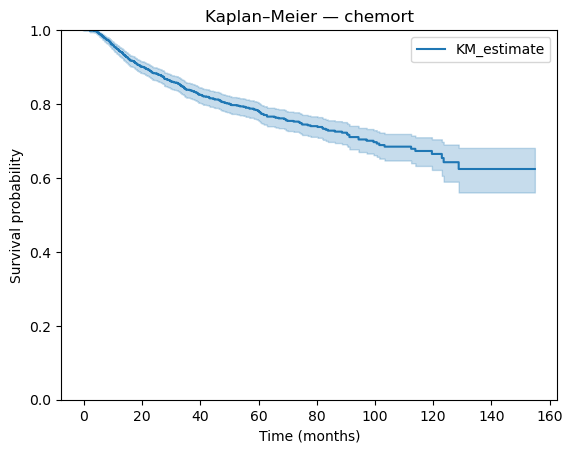

death_flag
0    1090
1     314
Name: count, dtype: int64


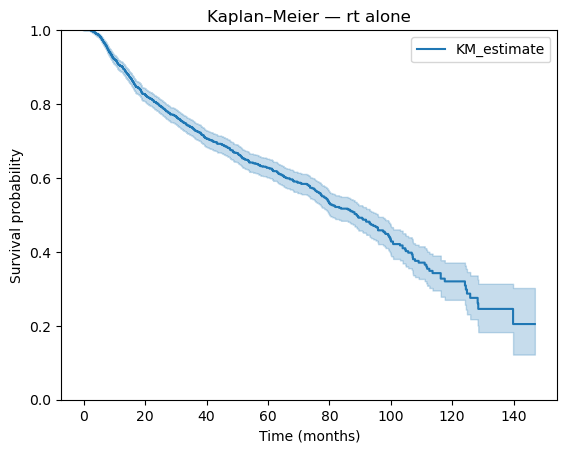

death_flag
0    1141
1     699
Name: count, dtype: int64


<bound method StatisticalResult.print_summary of <lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         119.10 <0.005     89.70>

In [35]:
#------- Kaplan-Meier Survival Curves for 2 groups (Treatment" ChemoRT and RT alone)

"""
def plot_kaplan_meier(data, colName):
    # Fit the Kaplan-Meier estimator
    kmf = KaplanMeierFitter()
    for col in data[colName].unique():
       subData = data.loc[data[colName] == col]
       print(subData['death_flag'].value_counts())
       kmf.fit(subData['time_months'], event_observed=subData['death_flag'], label = col)
    
    # Plot the Kaplan-Meier curve
    kmf.plot_survival_function()
    plt.title(f'Kaplan-Meier - {colName}')
    plt.xlabel('Time (Months)')
    plt.ylabel('Survival Probability')
    plt.tight_layout()
    plt.show()
"""

#plot for group  1: chemrt 
kmf = KaplanMeierFitter()
kmf.fit(chemort['time_months'], event_observed=chemort['death_flag'])
kmf.plot_survival_function()
plt.title('Kaplan–Meier — chemort')
plt.xlabel('Time (months)'); plt.ylabel('Survival probability'); plt.ylim(0,1)
plt.show()
print(chemort['death_flag'].value_counts())

#plot for group 2: rt alone 
kmf = KaplanMeierFitter()
kmf.fit(rt['time_months'], event_observed=rt['death_flag'])
kmf.plot_survival_function()
plt.title('Kaplan–Meier — rt alone')
plt.xlabel('Time (months)'); plt.ylabel('Survival probability'); plt.ylim(0,1)
plt.show()
print(rt['death_flag'].value_counts())

#Log rank test for group 1
results = logrank_test(
    chemort['time_months'], rt['time_months'],
    event_observed_A=chemort['death_flag'],
    event_observed_B=rt['death_flag']
)
results.print_summary
#log rank test for group 2

### Cox Propirtional Hazards Regression 

Sex
Male      2644
Female     675
Name: count, dtype: int64
treatment_type
rt alone           1840
chemort            1404
rt + egfri           72
postop rt alone       3
Name: count, dtype: int64
time_months                       float64
death_flag                          int64
Age                               float64
Sex_Male                             bool
cancer_stage_I                       bool
cancer_stage_IB                      bool
cancer_stage_II                      bool
cancer_stage_IIA                     bool
cancer_stage_IIB                     bool
cancer_stage_III                     bool
cancer_stage_IIIA                    bool
cancer_stage_IIIC                    bool
cancer_stage_IV                      bool
cancer_stage_IVA                     bool
cancer_stage_IVB                     bool
cancer_stage_IVC                     bool
cancer_stage_X                       bool
treatment_type_postop rt alone       bool
treatment_type_rt + egfri            bool
treat

<lifelines.CoxPHFitter: fitted with 3319 total observations, 2269 right-censored observations>
             duration col = 'time_months'
                event col = 'death_flag'
      baseline estimation = breslow
   number of observations = 3319
number of events observed = 1050
   partial log-likelihood = -7654.92
         time fit was run = 2025-08-13 07:13:55 UTC

---
                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                        
Age                              0.04      1.04      0.00            0.03            0.04                1.03                1.04
Sex_Male                         0.04      1.04      0.08           -0.11            0.19                0.89                1.21
cancer_stage_I                  -0.21      0.81      0.34           -0.87            0.45                0.42                1.56
cancer_stage_IB                -16.93      0.00  22470.26       -44057.82        44023.96                0.00                 inf
cancer_stage_II                  0.07      1.07      0.33           -0.58            0.72                0.56                2.04
cancer_stage_IIA               -11.22      0.00    589.47        -1166.55         1144.12                0.00                 inf
cancer_stage_IIB                 2.14      8.50      1.05            0.08            4.20                1.08               66.65
cancer_stage_III                 0.45      1.57      0.33           -0.18            1.09                0.83                2.97
cancer_stage_IIIA                2.79     16.24      0.78            1.26            4.31                3.54               74.61
cancer_stage_IIIC                2.72     15.15      0.78            1.20            4.24                3.31               69.34
cancer_stage_IV                  1.17      3.21      0.50            0.20            2.14                1.22                8.49
cancer_stage_IVA                 0.77      2.17      0.32            0.14            1.40                1.15                4.06
cancer_stage_IVB                 1.58      4.83      0.33            0.93            2.22                2.54                9.20
cancer_stage_IVC               -12.74      0.00   1484.36        -2922.02         2896.55                0.00                 inf
cancer_stage_X                   1.86      6.42      0.59            0.70            3.02                2.01               20.51
treatment_type_postop rt alone   1.96      7.07      0.71            0.56            3.35                1.75               28.56
treatment_type_rt + egfri        0.53      1.70      0.18            0.17            0.89                1.19                2.43
treatment_type_rt alone          0.77      2.15      0.08            0.61            0.92                1.84                2.52

                                cmp to     z      p  -log2(p)
covariate                                                    
Age                               0.00 11.33 <0.005     96.36
Sex_Male                          0.00  0.52   0.60      0.73
cancer_stage_I                    0.00 -0.64   0.53      0.93
cancer_stage_IB                   0.00 -0.00   1.00      0.00
cancer_stage_II                   0.00  0.21   0.84      0.26
cancer_stage_IIA                  0.00 -0.02   0.98      0.02
cancer_stage_IIB                  0.00  2.04   0.04      4.58
cancer_stage_III                  0.00  1.39   0.16      2.61
cancer_stage_IIIA                 0.00  3.58 <0.005     11.52
cancer_stage_IIIC                 0.00  3.50 <0.005     11.08
cancer_stage_IV                   0.00  2.35   0.02      5.75
cancer_stage_IVA                  0.00  2.41   0.02      5.96
cancer_stage_IVB                  0.00  4.80 <0.005     19.25
cancer_stage_IVC                  0.00 -0.01   0.99      0.01
cancer_stage_X                   

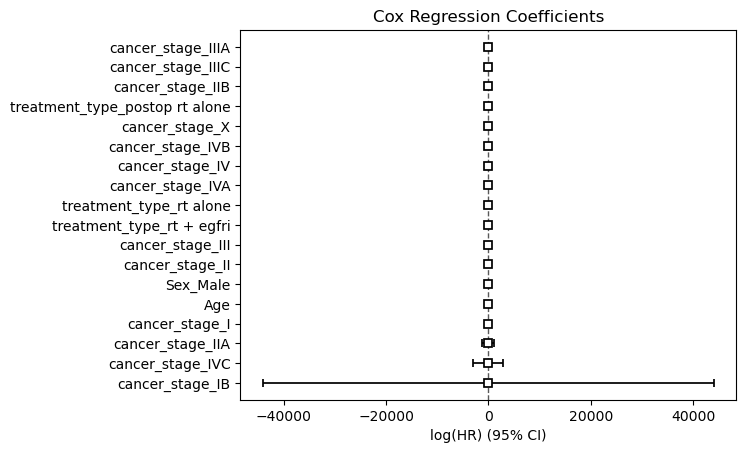


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3319 total observations, 2269 right-censored observations>
         test_name = proportional_hazard_test

---
                                     test_statistic      p  -log2(p)
Age                            km             13.29 <0.005     11.87
                               rank           12.21 <0.005     11.04
Sex_Male                       km              2.32   0.13      2.97
                               rank            2.56   0.11      3.19
cancer_stage_I                 km              0.90   0.34      1.55
                               rank            0.26   0.61      0.71
cancer_stage_IB                km              0.00   1.00      0.00
                               rank            0.00   1.00      0.00
cancer_stage_II                km              0.15   0.70      0.52
                               rank            0.01   0.93      0.11
cancer_stage_IIA               km              0.00   1.00      0.00
                               rank            0.00   1.00      0.00
cancer_stage_IIB               km              0.01   0.91      0.13
                               rank            0.01   0.94      0.09
cancer_stage_III               km              0.70   0.40      1.31
                               rank            1.19   0.28      1.86
cancer_stage_IIIA              km              0.00   0.94      0.08
                               rank            0.00   1.00      0.00
cancer_stage_IIIC              km              0.00   0.98      0.03
                               rank            0.00   0.95      0.07
cancer_stage_IV                km              0.29   0.59      0.77
                               rank            0.45   0.50      1.00
cancer_stage_IVA               km              1.19   0.27      1.86
                               rank            2.01   0.16      2.68
cancer_stage_IVB               km              3.55   0.06      4.07
                               rank            5.67   0.02      5.86
cancer_stage_IVC               km              0.00   1.00      0.00
                               rank            0.00   1.00      0.00
cancer_stage_X                 km              0.90   0.34      1.55
                               rank            1.15   0.28      1.82
treatment_type_postop rt alone km              0.45   0.50      1.00
                               rank            0.46   0.50      1.01
treatment_type_rt + egfri      km              0.53   0.47      1.10
                               rank            0.71   0.40      1.33
treatment_type_rt alone        km              0.03   0.87      0.20
                               rank            0.68   0.41      1.28



1. Variable 'Age' failed the non-proportional test: p-value is 0.0003.

   Advice 1: the functional form of the variable 'Age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Age' using pd.cut, and then specify it in `strata=['Age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment..

[[<Axes: xlabel='rank-transformed time\n(p=0.0005)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0003)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1094)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1281)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.6129)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3419)'>],
 [<Axes: xlabel='rank-transformed time\n(p=1.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=1.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9293)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6996)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9988)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9989)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9415)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9130)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2760)'>,
  <Axes: xlabel='km-transformed time\n(p=0.4029)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9976)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9443)'>],
 [<Axes: xlabel='rank-transformed tim

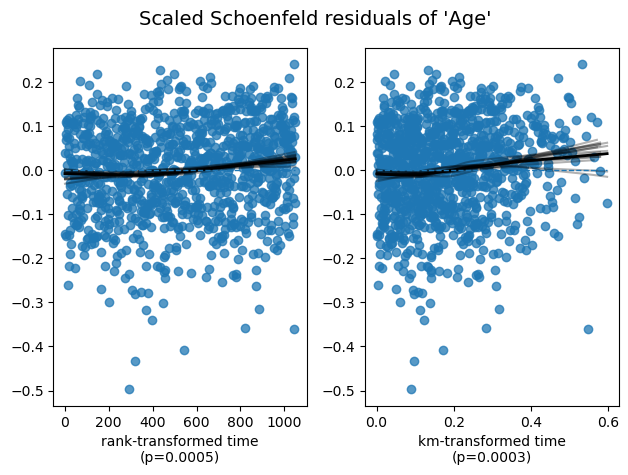

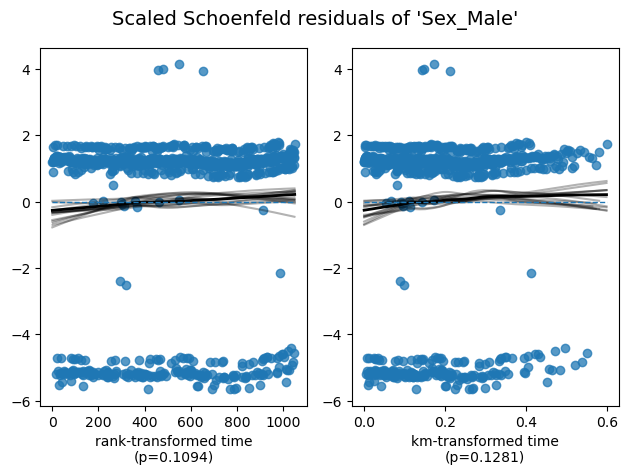

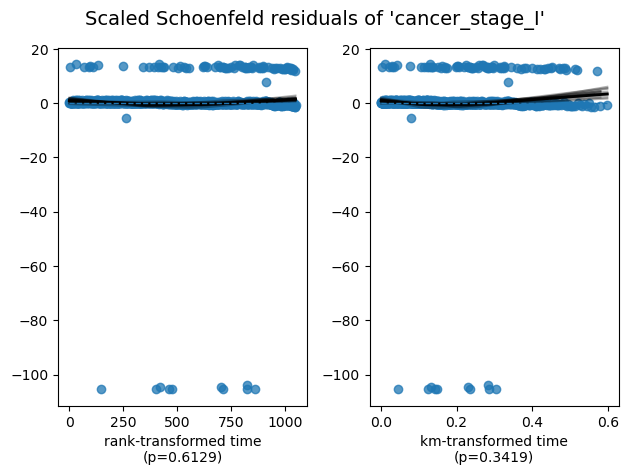

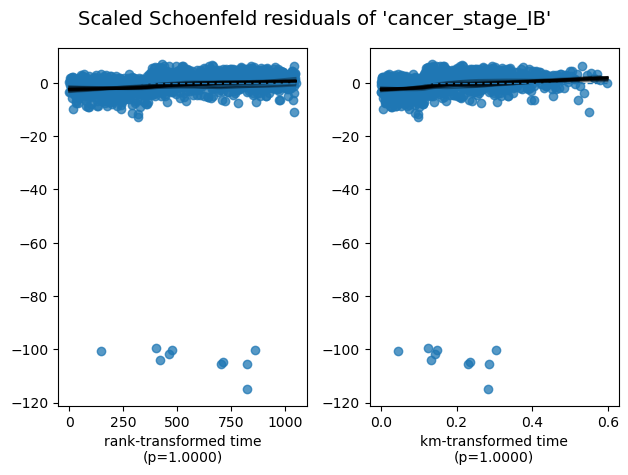

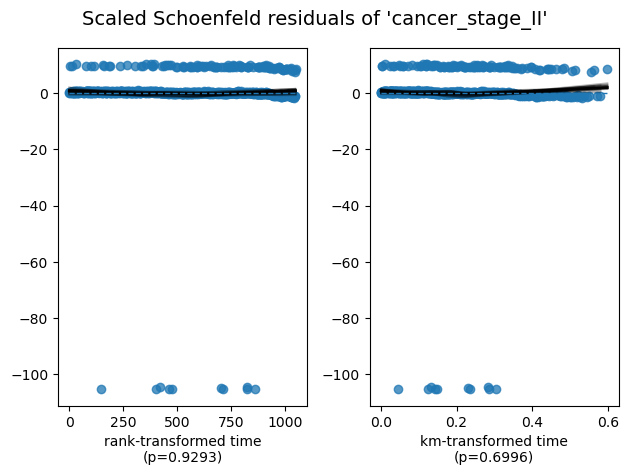

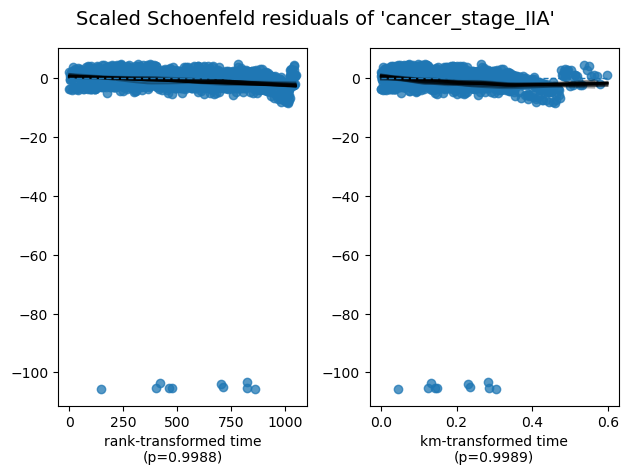

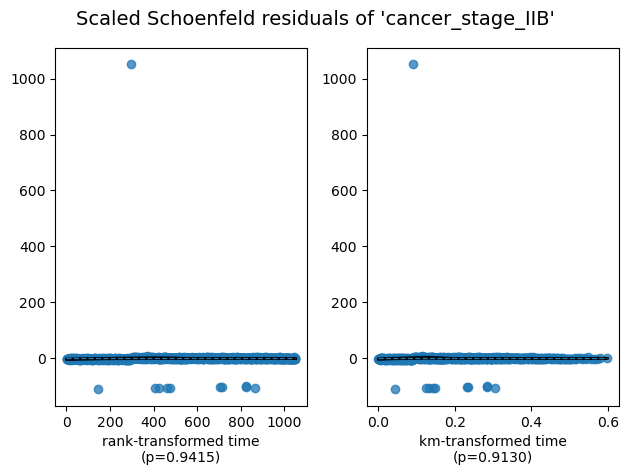

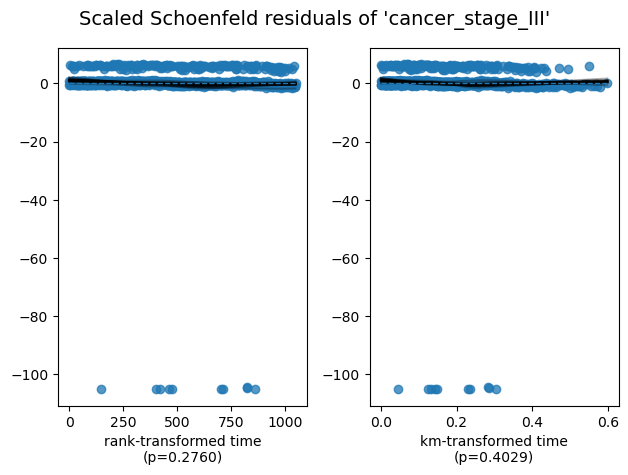

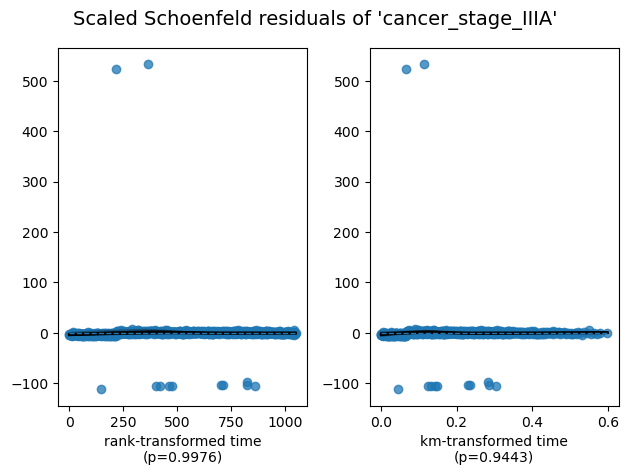

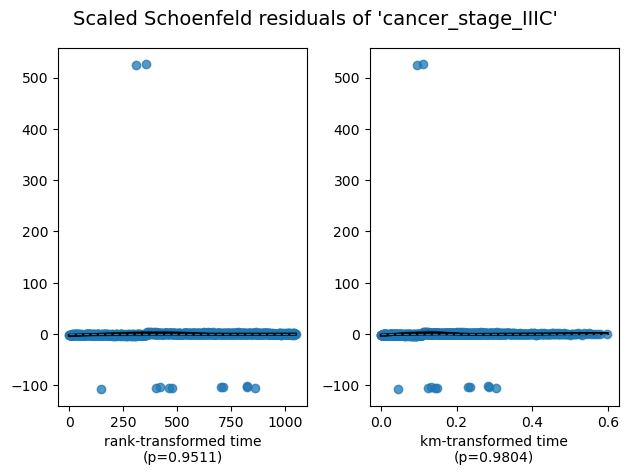

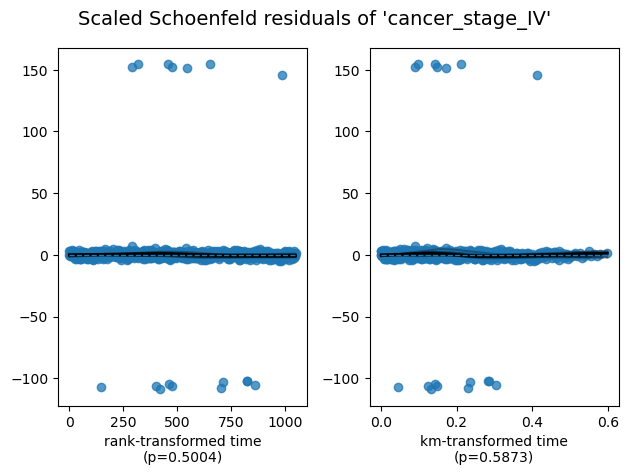

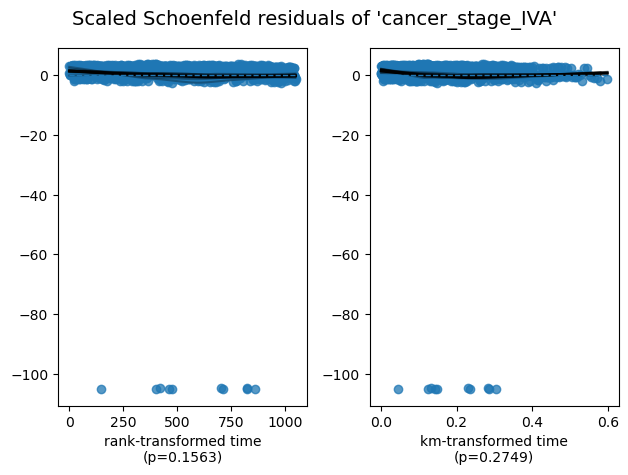

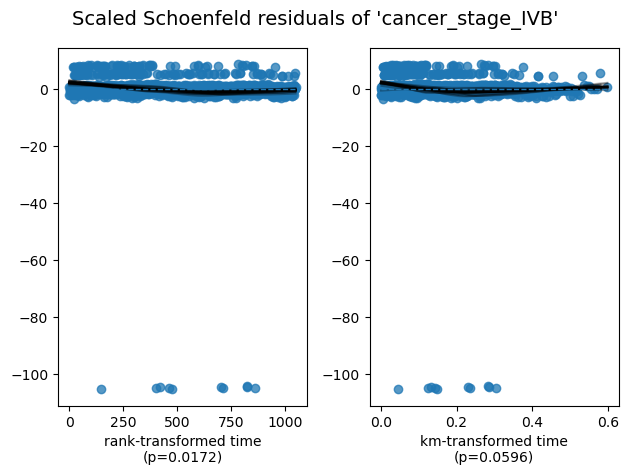

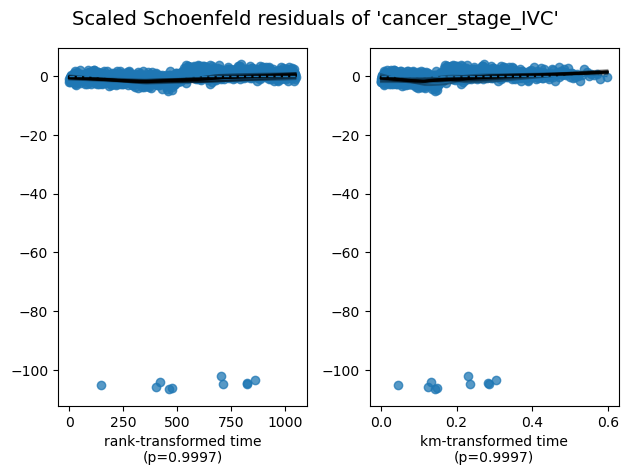

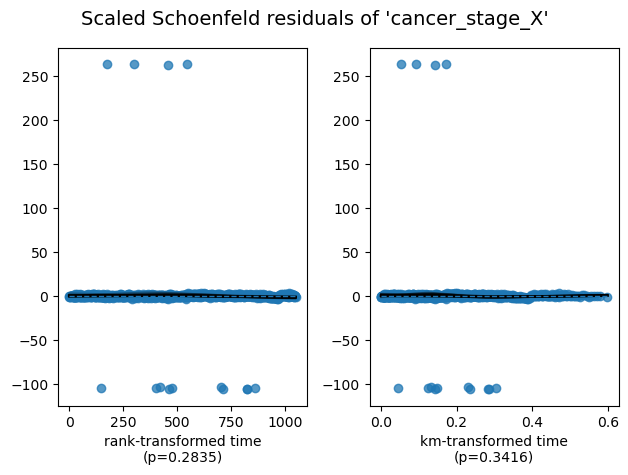

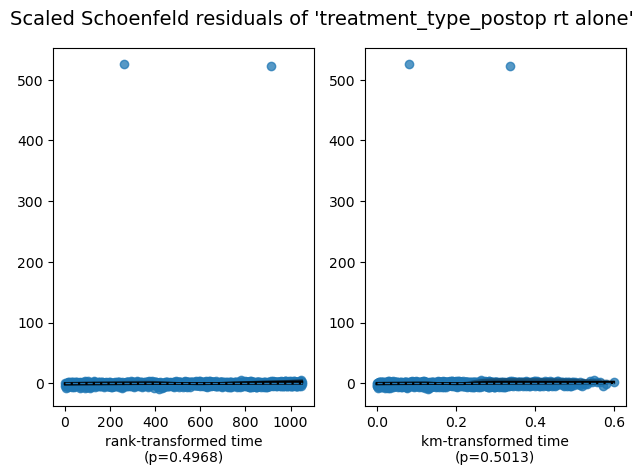

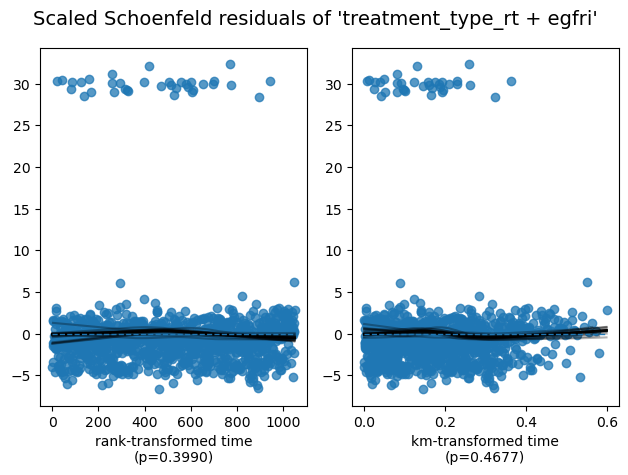

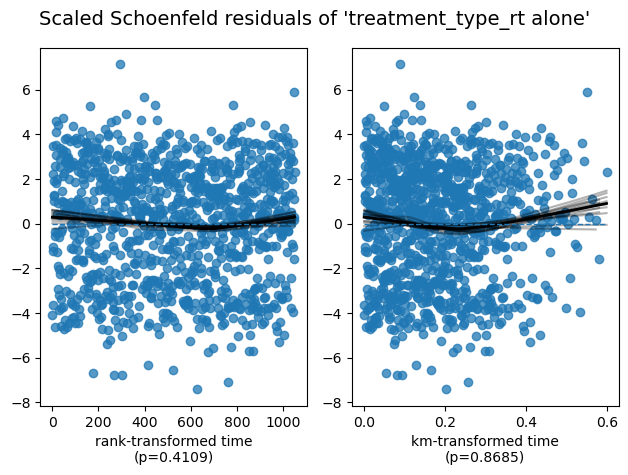

In [ ]:
#----- Cox regression with at lead 3 covariates 
covariates = ['Age', 'Sex', 'cancer_stage', 'treatment_type']

df_cph = clean_data[['time_months', 'death_flag'] + covariates].copy()
df_cph = df_cph.dropna(subset=['time_months', 'death_flag']+ covariates)

covariates = ['Age', 'Sex', 'cancer_stage', 'treatment_type']

print(df_cph['Sex'].value_counts())
print(df_cph['treatment_type'].value_counts())

cat_vars = ['Sex', 'cancer_stage', 'treatment_type']
df_cph = pd.get_dummies(df_cph, columns=cat_vars, drop_first=True)

#print(df_cph.dtypes)

# Fit the Cox proportional hazards model
cph = CoxPHFitter()
cph.fit(df_cph, duration_col='time_months', event_col='death_flag')

# Print the summary of the model
cph.print_summary()

# Plot the coefficients
cph.plot()
plt.title('Cox Regression Coefficients')
plt.show()

#validate proptional hazard Assumptions
cph.check_assumptions(df_cph, p_value_threshold=0.05, show_plots=True)

### Random Survival Forests (RSF)

In [ ]:
## build random survival forest model 

# preform vairabl eimporance analysis to find predicitve factors

## RSF vs Cox Comparison

In [ ]:
## compare RSF models concordance index (C-index) with Cox regression 